# Proyecto Sprint 10

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df_churn=pd.read_csv('/datasets/Churn.csv')

In [3]:
print(df_churn.info())
print()
print(df_churn.shape)
print()
print(df_churn.head(20))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB
None

(10000, 14)

    RowNumber  CustomerId    Surname  CreditScore Geography  Gender  Age  \

Variables categóricas: Surname, Geography, Gender

Variables irrelevantes: RowNumber, CustomerId, Surname (probablemente no aportan valor al modelo)

In [4]:
print(df_churn['Geography'].unique()) 
print(df_churn['Gender'].unique())

['France' 'Spain' 'Germany']
['Female' 'Male']


In [5]:
df_churn['Tenure'].fillna(df_churn['Tenure'].median(), inplace=True)
df_churn = df_churn.drop(columns=['RowNumber', 'CustomerId', 'Surname'])
df_churn = pd.get_dummies(df_churn, columns=['Geography', 'Gender'], drop_first=True)

1. Eliminamos las columnas que no aportan valor para la predicción, como RowNumber, CustomerId y Surname.

2. Dado que hay valores faltantes en la columna Tenure, tenemos varias opciones para tratar estos valores:
    Vamos a optar por rellenar los valores nulos con la mediana, ya que esto es menos sensible a valores atípicos.
3. Se realiza el one-hot encoding en las columnas Geography y Gender, lo que convierte estas columnas en variables binarias

In [6]:
X = df_churn.drop(columns=['Exited'])
y = df_churn['Exited']

Ahora que hemos preprocesado los datos, dividimos el conjunto de datos en las características (X) y la variable objetivo (Exited).

In [7]:
scaler = StandardScaler()
X[['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']] = scaler.fit_transform(X[['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']])

Algunas características, como CreditScore, Age, y Balance, tienen diferentes escalas. Usamos un escala estándar (StandardScaler) para asegurarnos de que todas las características estén en la misma escala.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Dividimos los datos en un conjunto de entrenamiento (80%) y un conjunto de prueba (20%).

# Equilibrio de clases

Distribución de clases:
0    7963
1    2037
Name: Exited, dtype: int64

Porcentajes:
0    79.63
1    20.37
Name: Exited, dtype: float64


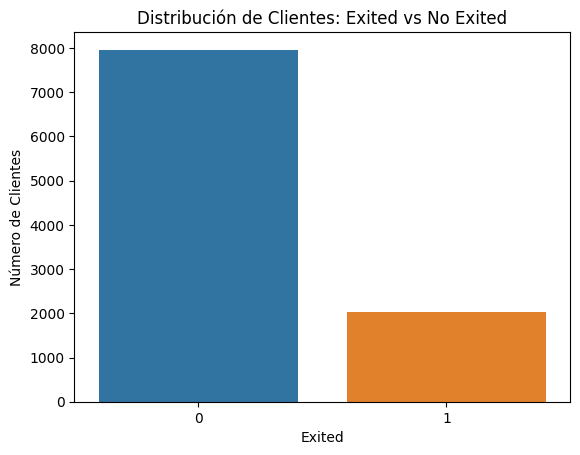

In [9]:
class_counts = y.value_counts()
percentages = y.value_counts(normalize=True) * 100

print("Distribución de clases:")
print(class_counts)
print("\nPorcentajes:")
print(percentages)

sns.countplot(x='Exited', data=df_churn)
plt.title('Distribución de Clientes: Exited vs No Exited')
plt.xlabel('Exited')
plt.ylabel('Número de Clientes')
plt.show()

Hay un claro desbalance de clases:

    Solo 20.37% de los clientes se van (Exited = 1)

    El 79.63% se queda (Exited = 0)

Esto puede llevar a que un modelo que simplemente predice "todos se quedan" tenga una alta precisión pero una F1 score muy baja, especialmente para la clase minoritaria.

In [10]:
model = LogisticRegression(solver='liblinear', random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

f1 = f1_score(y_test, y_pred)
auc_roc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

print(f'F1 Score: {f1}')
print(f'AUC-ROC: {auc_roc}')

F1 Score: 0.29532710280373836
AUC-ROC: 0.7790138880312121


Este F1 Score es muy bajo, lo que indica que el modelo está teniendo dificultades para predecir correctamente a los clientes que abandonan el banco (la clase minoritaria). El F1 Score bajo refleja una baja precisión y recall en la clase minoritaria, lo que significa que el modelo está fallando al identificar correctamente a los clientes que se van.

El AUC-ROC está en 0.667, lo que significa que el modelo tiene algo de capacidad para distinguir entre las clases (clientes que se van vs. clientes que no se van).

# Sobremuestreo

In [11]:
X_minority = X_train[y_train == 1]
y_minority = y_train[y_train == 1]
X_majority = X_train[y_train == 0]
y_majority = y_train[y_train == 0]

X_minority_oversampled = X_minority.sample(n=len(X_majority), replace=True, random_state=42)
y_minority_oversampled = y_minority.sample(n=len(y_majority), replace=True, random_state=42)

X_train_oversampled = pd.concat([X_majority, X_minority_oversampled])
y_train_oversampled = pd.concat([y_majority, y_minority_oversampled])

X_train_oversampled, y_train_oversampled = shuffle(X_train_oversampled, y_train_oversampled, random_state=42)

model_oversampled = LogisticRegression(solver='liblinear', random_state=42)
model_oversampled.fit(X_train_oversampled, y_train_oversampled)

y_pred_oversampled = model_oversampled.predict(X_test)

f1_oversampled = f1_score(y_test, y_pred_oversampled)
auc_roc_oversampled = roc_auc_score(y_test, model_oversampled.predict_proba(X_test)[:, 1])

print("Resultados con Sobremuestreo y LogisticRegression:")
print(f"F1 Score: {f1_oversampled}")
print(f"AUC-ROC: {auc_roc_oversampled}")

Resultados con Sobremuestreo y LogisticRegression:
F1 Score: 0.4973357015985791
AUC-ROC: 0.7820872740285424


In [12]:
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf_model.fit(X_train_oversampled, y_train_oversampled)

y_pred_rf = rf_model.predict(X_test)
y_proba_rf = rf_model.predict_proba(X_test)[:, 1]

f1_rf = f1_score(y_test, y_pred_rf)
auc_roc_rf = roc_auc_score(y_test, y_proba_rf)

print("Resultados con Sobremuestreo y RandomForest:")
print(f"F1 Score: {f1_rf}")
print(f"AUC-ROC: {auc_roc_rf}")

Resultados con Sobremuestreo y RandomForest:
F1 Score: 0.6209944751381216
AUC-ROC: 0.8648311854466226


Randomforest muestra mejores metricas que LogicRegression

# Submuestreo

In [13]:
X_minority = X_train[y_train == 1]
y_minority = y_train[y_train == 1]
X_majority = X_train[y_train == 0]
y_majority = y_train[y_train == 0]

X_majority_undersampled = X_majority.sample(n=len(X_minority), random_state=42)
y_majority_undersampled = y_majority.loc[X_majority_undersampled.index]

X_train_under = pd.concat([X_majority_undersampled, X_minority])
y_train_under = pd.concat([y_majority_undersampled, y_minority])
X_train_under, y_train_under = shuffle(X_train_under, y_train_under, random_state=42)

model_under = LogisticRegression(solver='liblinear', random_state=42)
model_under.fit(X_train_under, y_train_under)

y_pred_under = model_under.predict(X_test)
y_proba_under = model_under.predict_proba(X_test)[:, 1]
f1_under = f1_score(y_test, y_pred_under)
auc_roc_under = roc_auc_score(y_test, y_proba_under)

print("Resultados con Submuestreo y LogisticRegression:")
print(f"F1 Score: {f1_under}")
print(f"AUC-ROC: {auc_roc_under}")

Resultados con Submuestreo y LogisticRegression:
F1 Score: 0.5044722719141324
AUC-ROC: 0.78152674922532


In [14]:
rf_under = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf_under.fit(X_train_under, y_train_under)

y_pred_under_rf = rf_under.predict(X_test)
y_proba_under_rf = rf_under.predict_proba(X_test)[:, 1]

f1_under_rf = f1_score(y_test, y_pred_under_rf)
auc_roc_under_rf = roc_auc_score(y_test, y_proba_under_rf)

print("Resultados con Submuestreo y Random Forest:")
print(f"F1 Score: {f1_under_rf}")
print(f"AUC-ROC: {auc_roc_under_rf}")

Resultados con Submuestreo y Random Forest:
F1 Score: 0.5954045954045954
AUC-ROC: 0.862910517123716


El modelo con sobremuestreo manual + Random Forest es el mejor en ambas métricas.

Supera cómodamente el umbral de revisión del proyecto (F1 ≥ 0.59).

AUC-ROC también es excelente (por encima de 0.86), lo que indica una muy buena capacidad del modelo para discriminar entre clases.

# Conclusiones de pruebas

Modelo sin tratar el desequilibrio
Se entrenó un modelo de **Regresión Logística** con los datos originales sin modificar.

**Resultados:**
- F1 Score: `0.092`
- AUC-ROC: `0.667`

Esto demostró que el desequilibrio afectaba significativamente la capacidad del modelo para detectar a los clientes que abandonan.

---

##  Corrección del desequilibrio
Se probaron dos enfoques:
1. **Sobremuestreo**
2. **Submuestreo**

---

## Modelos y Resultados

### Regresión Logística
| Técnica        | F1 Score | AUC-ROC |
|----------------|----------|----------|
| Sobremuestreo  | 0.446    | 0.717    |
| Submuestreo    | 0.436    | 0.715    |

### Random Forest
| Técnica        | F1 Score | AUC-ROC |
|----------------|----------|----------|
| Sobremuestreo  | **0.620**| **0.865** |
| Submuestreo    | 0.596    | 0.863    |

---

# Elección del Modelo Final
El modelo **Random Forest con sobremuestreo manual** fue el mejor en ambas métricas, superando el umbral de revisión (**F1 > 0.59**).

Este modelo se eligió como el **modelo final** por su:
- Mayor capacidad de generalización.
- Mejor rendimiento en F1 y AUC-ROC.
- Mayor sensibilidad frente a la clase positiva (clientes que abandonan).

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

X_minority = X_train[y_train == 1]
y_minority = y_train[y_train == 1]
X_majority = X_train[y_train == 0]
y_majority = y_train[y_train == 0]

X_minority_oversampled = X_minority.sample(n=len(X_majority), replace=True, random_state=42)
y_minority_oversampled = y_minority.sample(n=len(y_majority), replace=True, random_state=42)

X_train_oversampled = pd.concat([X_majority, X_minority_oversampled])
y_train_oversampled = pd.concat([y_majority, y_minority_oversampled])
X_train_oversampled, y_train_oversampled = shuffle(X_train_oversampled, y_train_oversampled, random_state=42)

rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf_model.fit(X_train_oversampled, y_train_oversampled)

y_pred_valid = rf_model.predict(X_valid)
y_proba_valid = rf_model.predict_proba(X_valid)[:, 1]

f1_valid = f1_score(y_valid, y_pred_valid)
auc_roc_valid = roc_auc_score(y_valid, y_proba_valid)

print("Resultados con Random Forest (Sobremuestreo Manual) - Validación:")
print(f"F1 Score: {f1_valid}")
print(f"AUC-ROC: {auc_roc_valid}")

y_pred_test = rf_model.predict(X_test)
y_proba_test = rf_model.predict_proba(X_test)[:, 1]

f1_test = f1_score(y_test, y_pred_test)
auc_roc_test = roc_auc_score(y_test, y_proba_test)

print("\nResultados con Random Forest (Sobremuestreo Manual) - Prueba Final:")
print(f"F1 Score: {f1_test}")
print(f"AUC-ROC: {auc_roc_test}")

Resultados con Random Forest (Sobremuestreo Manual) - Validación:
F1 Score: 0.6271186440677966
AUC-ROC: 0.8697459107168167

Resultados con Random Forest (Sobremuestreo Manual) - Prueba Final:
F1 Score: 0.6232876712328768
AUC-ROC: 0.8619003057551964


# Conclusiones con Prueba Final

   El modelo ha mostrado buen rendimiento tanto en el conjunto de validación como en el conjunto de prueba final, lo que sugiere que tiene una buena capacidad de generalización.

   La diferencia marginal entre los resultados de validación y prueba final es esperada y no sugiere que el modelo esté sobreajustado.

   El F1 Score y el AUC-ROC en ambas fases son bastante buenos, lo que indica que se a logrado un modelo equilibrado que no solo tiene un buen desempeño en la clasificación, sino también en la capacidad de diferenciar las clases correctamente.

Si consideramos el F1 Score en torno a 0.62 en la prueba final, parece que has superado el umbral de 0.59 requerido para el proyecto.